In [2]:
# Run this cell (shift + enter) to start.
import tutorial

In [3]:
import torch
import numpy as np

# PyTorch basics

## It is just like NumPy

In [4]:
x = torch.arange(12).reshape(4, 3)
print(x)
third_row = x[2, :]
print("Third row:", third_row)

tensor([[ 0,  1,  2],
        [ 3,  4,  5],
        [ 6,  7,  8],
        [ 9, 10, 11]])
Third row: tensor([6, 7, 8])


In [5]:
x = np.arange(12).reshape(4, 3)
print(x)
third_row = x[2, :]
print("Third row:", third_row)

[[ 0  1  2]
 [ 3  4  5]
 [ 6  7  8]
 [ 9 10 11]]
Third row: [6 7 8]


The correspondence is not exactly 1–1, but there exist handy [translation tables](https://github.com/wkentaro/pytorch-for-numpy-users) for NumPy users.

## GPU execution

Variables can be allocated on a GPU

In [6]:
x = torch.arange(12, device='cuda').reshape(4, 3)

or moved there from the cpu, (and back)

In [7]:
a = torch.tensor(2).to('cuda')
b = torch.tensor(3).to('cuda')
c = a + b  # This is done by your GPU
c_on_cpu = c.to('cpu')
print(c_on_cpu)

tensor(5)


## Automatic differentiation

Like TensorFlow, PyTorch can track a tensor's computation history, and automatically compute gradients w.r.t. input tensors. This is enabled with `requires_grad=True`:

In [11]:
# Let's use autodiff to find the slope of a x + b
x = torch.randn(1, requires_grad=True)  # sample from a standard normal distribution
print("x =", x)

y = 2 * x + 3
print("y =", y)

# Differentiate y w.r.t. all inputs that have `requires_grad=True`:
y.backward()

# `.backard()` *adds* the gradients to `variable`.grad for each of the inputs
print("grad x =", x.grad)

x = tensor([1.1579], requires_grad=True)
y = tensor([5.3158], grad_fn=<AddBackward0>)
grad x = tensor([2.])


### Avoiding autodiff for parameter updates

When updating model parameters in SGD, you want to avoid tracking that update for automatic differentiation. 
You can do this by updating the *raw storage* of the parameter with `tensor.data`:

In [12]:
# Normally, every change to a parameter is recorded:
x = torch.ones(2, requires_grad=True)
x = x + 2.0
print("Tracked addition:  ", x)

# This updates the tensor 'secretly' by updating the tensor's raw storage:
# This is how we do model parameter updates
x = torch.ones(2, requires_grad=True)
x.data = x + 2.0
print("Untracked addition:", x)

Tracked addition:   tensor([3., 3.], grad_fn=<AddBackward0>)
Untracked addition: tensor([3., 3.], requires_grad=True)


# A first neural network in PyTorch
This section is based on [Pytorch tutorial](https://github.com/ahug/amld-pytorch-workshop) from Andreas Hug and Evann Courdier.

In [13]:
import torchvision

To implement a neural network, you need to define a PyTorch module with two methods: `__init__` and `forward`. You define a simple linear model as follows:

In [14]:
class LinearNetwork(torch.nn.Module):
    def __init__(self, input_size, num_classes):
        """"
        In the `__init__` method, you define all the layers with trainable parameters.
        The order does not matter.
        """
        super(MySuperSimpleNetwork, self).__init__()  # Mandatory to call Super
        self.linear = torch.nn.Linear(input_size, num_classes)  # Define one Linear layer
    
    def forward(self, network_input):
        """
        In the `forward` method, you run the network, composing the building blocks
        defined in `__init__` in the order you want.
        """
        return self.linear(network_input)

Let's now create a more realistic network for image classification. 
Your first exercise is to implement a simple multilayer perceptron (MLP) with two fully-connected hidden layers and *ReLU* nonlinearities between them.

Use the following number of 'neurons' per layer:

<table>
    <thead>
        <tr>
            <th>Layer</th>
            <th># of neurons</th>
        </tr>
    </thead>
    <tbody>
        <tr><th>Input</th><td><code>input_size</code></td></tr>
        <tr><th>1st hidden layer</th><td>75</td></tr>
        <tr><th>2nd hidden layer</th><td>50</td></tr>
        <tr><th>Output layer</th><td><code>num_classes</code></td></tr>
    </tbody>
</table>


In [15]:
class MyMultilayerPerceptron(torch.nn.Module):
    def __init__(self, input_size, num_classes):
        super(MyMultilayerPerceptron, self).__init__()
        
        self.input_size = input_size
        self.num_classes = num_classes
        
        ###### INSERT YOUR CODE HERE #########
        self.linear = torch.nn.Linear(input_size, 75)
        self.linear_2 = torch.nn.Linear(75, 50)
        self.linear_3 = torch.nn.Linear(50, num_classes)
        ######################################
        
    
    def forward(self, x):
        out = x.view(x.size(0), -1)
        ###### INSERT YOUR CODE HERE #########
        # Hint: the 'ReLU' function is torch.nn.functional.relu
        # ...
        # ...
        ######################################
        out = self.linear(out)
        out = torch.nn.functional.relu(out)
        out = self.linear_2(out)
        out = torch.nn.functional.relu(out)
        out = self.linear_3(out)
        return out


# The CIFAR10 dataset 

We will work with 2 class subset of [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset. This dataset contains 32x32 color images of 'airplanes' and 'automobiles' with their labels. There are 5000 of these images per category in the training set, and 1000 each in the test set. We use only 2 out of 10 CIFAR10 classes to save time during the tutorial.

In [16]:
# We provide an implementation of the 2-class subset of CIFAR10.
# If you wanted to use the full dataset, use torchvision.datasets.CIFAR10
from tutorial import TwoClassCIFAR

In [17]:
# We load both the training- and test sets into memory
training_set = TwoClassCIFAR(train=True, transform=torchvision.transforms.ToTensor())
test_set = TwoClassCIFAR(train=False, transform=torchvision.transforms.ToTensor())

# And define loaders that allow us to iterate over the dataset in batches
training_loader = torch.utils.data.DataLoader(training_set, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=250, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [18]:
# Each image of CIFAR10 consists has 32x32 pixels with 3 color channels (red, green, and blue)
# With this information, the number of inputs to the neural network follows as
input_size = 3 * 32 * 32

# SGD "by hand"

With the dataset and a model set up, it is now time to train the model.

We will optimize the multi-layer perceptron "by hand" using the gradient descent algorithm. It is good practice to use PyTorch' built-in optimizers, but we will first implement SGD from basic building blocks for educational purposes :)

As a reminder, the update step of the algorithm is:
$$x_{t+1} = x_{t} - \lambda \nabla_x f (x_t).$$

The training procedures are structured as:
* loop over epochs
* loop over training data 
* forward pass (make a prediction)
* zero gradients: reset the gradient buffers from the previous iteration to zero
* backward pass (compute the mini-batch gradient)
* update the model parameters

**Exercise:** Implement Stochastic Gradient Descent with a constant learning rate.

Note:
- The gradient information $\nabla_x f (x)$ for a parameter `param` is stored in `param.grad` after running `loss.backward()`.
- We need to update the parameters by changing the raw storage with `param.data = ...`. This prevents autograd from tracking this change.
- `model.parameters()` gives the list of all parameters in the model.

In [45]:
def sgd(model: torch.nn.Module, num_epochs: int, lr: float):
    plot = tutorial.LivePlot(legend=["Training loss"])  # Track trainig errors
    
    model.to("cuda")  # This moves all model parameters to the GPU
    criterion = torch.nn.CrossEntropyLoss()  # The loss function
    
    losses = []  # Keep track of the training loss values that we encounter
    
    # Passes over the whole training set
    for epoch in range(num_epochs):
        cumulative_loss = 0.0
        
        # Loop over mini-batches
        for (inputs, labels) in training_loader:
            # `inputs` has shape (batch size, rgb, height, width)
            # `labels` has shape (batch size)
            inputs, labels = inputs.to("cuda"), labels.to("cuda")
            
            # Forward pass
            outputs = model(inputs)  # pre-softmax probabilities, shape: (batch size, num_classes)
            loss = criterion(outputs, labels)
            
            # Resetting the gradient buffers from the last iteration
            model.zero_grad()
            
            # Gradient computation
            loss.backward()

            # Parameters update with SGD step
            ###### INSERT YOUR CODE HERE #########
            # ...
            # ...
            ######################################
            for param in model.parameters():
                param.data -= lr * param.grad.data

            cumulative_loss += loss.item()  # .item() transforms a torch Tensor with a single number to a 'float'

        plot.add_point(epoch, cumulative_loss)
        losses.append(cumulative_loss)
        
    return losses

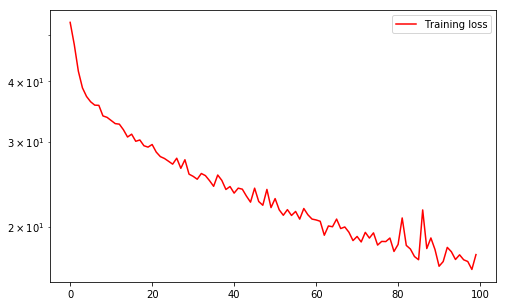

In [46]:
%matplotlib inline

model = MyMultilayerPerceptron(input_size, 2)
lr = 0.01
num_epochs = 100
sgd_losses = sgd(model, num_epochs, lr)

## Test accuracy

**Exercise:** Implement function to compute the accuracy on the test set. You can use `torch.argmax(..., dim=1)` to translate class probabilities (the model output) to predicted labels. 

For two torch tensors `a` and `b`, `a.eq(b)` gives a tensor of elementwise comparison of these two tensors (1 if corresponding entries are equal and 0 if not). 

In [58]:
def accuracy(model, data_loader):
    accuracies_per_batch = []
    for (inputs, labels) in data_loader:
        # `inputs` has shape (batch size, rgb, height, width)
        # `labels` has shape (batch size)
        inputs, labels = inputs.to("cuda"), labels.to("cuda")
        ###### INSERT YOUR CODE HERE #########
        # 1) predict with forward pass
        outputs = model(inputs)
        # 2) get predicted labels
        labels_predict = torch.argmax(outputs, dim=1)
        # 3) compare with true labels
        sum1 = 0
        for i in range(len(labels)):
            if labels_predict[i] == labels[i]:
                sum1 += 1
        # 4) get mean of number of correct preditcions
        m = sum1 / len(labels)
        accuracies_per_batch.append(m)
#         accuracies_per_batch.append(batch_accuracy.item())
        ######################################
        
    return np.mean(accuracies_per_batch)

In [59]:
print("Train accuracy:", accuracy(model, training_loader))
print("Test accuracy:", accuracy(model, test_loader))

Train accuracy: 0.8704509493670886
Test accuracy: 0.8454999999999999


## Adding Momentum

Let's now implement SGD with momentum

Recall that the update step of the SGD with momentum is:
$$m_{t+1} = \beta m_{t} + \nabla_x f (x_t),$$
$$x_{t+1} = x_{t} - \lambda m_{t + 1}.$$

This is equivalent to the momentum discussed in class.

In [71]:
def sgd_with_momentum(model, num_epochs, lr, mom=0.9):
    plot = tutorial.LivePlot(legend=['Training loss'])
    
    model.to("cuda")
    
    criterion = torch.nn.CrossEntropyLoss()
    
    losses = []
    
    # Create a momentum buffer for each parameter, initialized at zero
    momentum_buffers = []
    for param in model.parameters():
        momentum_buffers.append(torch.zeros_like(param))
        
    # Passes over the whole dataset
    for epoch in range(num_epochs):
        cumulative_loss = 0.0
        
        # Loop over batches in the dataset
        for (inputs, labels) in training_loader:
            inputs, labels = inputs.to("cuda"), labels.to("cuda")
            
            # Run the model
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Reset gradient buffers
            model.zero_grad()
            
            # Compute the gradient
            loss.backward()

            # SGD step with Momentum
            ###### INSERT YOUR CODE HERE #########
            # ...
            # ...
            # ...
            ######################################
            i = 0
            for param in model.parameters():
                d = param.grad.data
                momentum_buffers[i] = mom * momentum_buffers[i] + d
                param.data -= lr * momentum_buffers[i]
                i += 1

            cumulative_loss += loss.item()
            
        plot.add_point(epoch, cumulative_loss)
        losses.append(cumulative_loss)

    return losses

Let's try the algorithm:

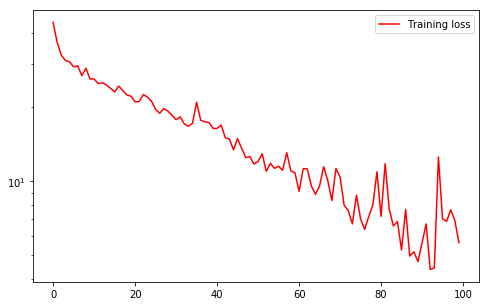

In [72]:
model = MyMultilayerPerceptron(input_size, 2)
lr = 0.01
num_epochs = 100
sgd_mom_losses = sgd_with_momentum(model, num_epochs, lr)

In [73]:
print("Train accuracy:", accuracy(model, training_loader))
print("Test accuracy:", accuracy(model, test_loader))

Train accuracy: 0.9721123417721519
Test accuracy: 0.8895


### Comparing SGD with SGD+Momentum

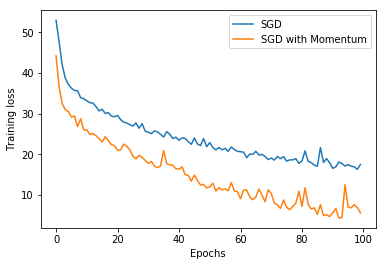

In [74]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.plot(sgd_losses, label="SGD")
plt.plot(sgd_mom_losses, label="SGD with Momentum")
plt.ylabel("Training loss")
plt.xlabel("Epochs")
plt.legend();

Which one is better? Why should you be skeptical about this result?

# Going deeper

Hoping to improve our classification performance, we will try LeNet-5—a network that is deeper than our toy-MLP.
![](https://pytorch.org/tutorials/_images/mnist.png)

In [78]:
class LeNet5(torch.nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        
        self.conv_net = torch.nn.Sequential(
            torch.nn.Conv2d(3, 6, kernel_size=(5, 5)),
            torch.nn.ReLU(),
            
            torch.nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            torch.nn.Conv2d(6, 16, kernel_size=(5, 5)),
            torch.nn.ReLU(),
            
            torch.nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            torch.nn.Conv2d(16, 120, kernel_size=(5, 5)),
            torch.nn.ReLU(),
        )
        
        self.fully_connected = torch.nn.Sequential(
            torch.nn.Linear(120, 84),
            torch.nn.ReLU(),
            torch.nn.Linear(84, 2),
            torch.nn.LogSoftmax(dim=-1)
        )


    def forward(self, imgs):
        output = self.conv_net(imgs)
        output = output.view(imgs.shape[0], -1)  # imgs.shape[0] == batch_size
        output = self.fully_connected(output)
        return output

### PyTorch's built-in optimizers
Luckily, you don't normally need to implement your own optimizers from scratch. PyTorch provides the most common optimization algorithms encapsulated into "optimizer classes".  
An optimizer is a useful object that automatically loops through all the numerous parameters of your model and performs the (potentially complex) update step for you.

Below are the most commonly used optimizers. Each of them have its specific parameters that you can check on the [PyTorch documentation](https://pytorch.org/docs/master/optim.html#algorithms).


```
optimizer = torch.optim.SGD(parameters, lr=0.01, momentum=0.9)
optimizer = torch.optim.Adam(parameters, lr=0.01)
optimizer = torch.optim.Adadelta(parameters, lr=0.01)
optimizer = torch.optim.Adagrad(parameters, lr=0.01)
optimizer = torch.optim.RMSprop(parameters, lr=0.01)
optimizer = torch.optim.LBFGS(parameters, lr=0.01)
```

 and there is more ...

Let's use oneo f these optimizers!

You will need 2 new functions:
- `optimizer.zero_grad()` : This function sets the gradient of the parameters (x here) to 0 (otherwise it will get accumulated)
- `optimizer.step()` :  This function applies an update step. You run this after computing gradients with `loss.backward()`.

In [80]:
def train(model: torch.nn.Module, num_epochs: int, data_loader, optimizer: torch.optim.Optimizer):
    plot = tutorial.LivePlot(legend=["Training loss"])
    
    model = model.to("cuda")
    
    # Define the Loss function and Optimizer that you want to use
    criterion = torch.nn.CrossEntropyLoss()
   
    # Outter training loop
    for epoch in range(num_epochs):
        
        # Inner training loop
        cumulative_loss = 0.0
        for (inputs, labels) in data_loader:
            # `inputs` has shape (batch size, rgb, height, width)
            # `labels` has shape (batch size)
            inputs, labels = inputs.to("cuda"), labels.to("cuda")

            # Do Forward -> Loss Computation -> Backward -> Optimization
            # And don't forget zero the gradient buffer!
            ######### INSERT YOUR CODE HERE #########
            # ...
            # ...
            # ...
            # ...
            # ...
            #########################################
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            model.zero_grad()
            
            loss.backward()

            optimizer.step()

            cumulative_loss += loss.item()

        plot.add_point(epoch, cumulative_loss)

## Hyperparameter optimization

The performance of an optimizer can heavily depend on the choice of learning rates, momentum parameter, batch sizes, and other hyperparameters. You can choose the best hyperparameters by basically just trying many of them and choosing the best one. Let's do this together. Everyone will receive one learning rate from us to try.

### Choosing a learning rate and batch size for SGD with momentum

Receive your own hyperparamters from the organizers!

In [81]:
learning_rate = tutorial.get_worker_value("learning-rate")
print("Your learning rate is ", learning_rate)

Your learning rate is  0.0032214868265606866


Train accuracy for batch size 512: 0.9101505055147058
Test accuracy for batch size 512: 0.9045000000000001


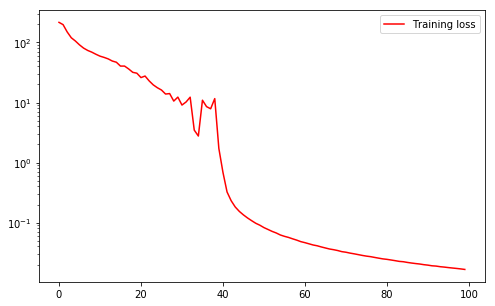

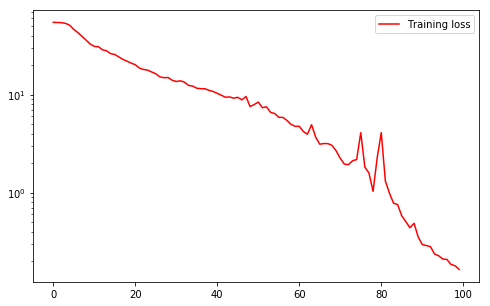

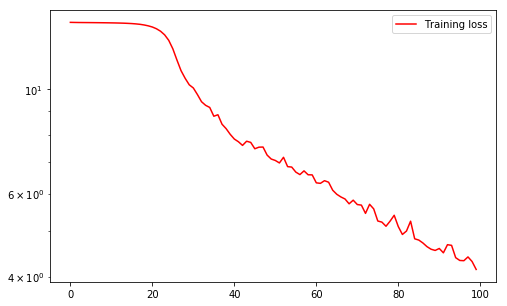

In [82]:
# Collect train and test accuracies for your learning rate

train_accuracies = {}  # batch size -> accuracy
test_accuracies = {}   # batch size -> accuracy

for batch_size in [32, 128, 512]:
    model = LeNet5()
    training_loader = torch.utils.data.DataLoader(
        training_set, 
        batch_size,
        shuffle=True
    )
    train(model, 100, training_loader, torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9))
    train_accuracies[batch_size] = accuracy(model, training_loader)
    test_accuracies[batch_size] = accuracy(model, test_loader)
    print(f"Train accuracy for batch size {batch_size}:", accuracy(model, training_loader))
    print(f"Test accuracy for batch size {batch_size}:", accuracy(model, test_loader))

# Send us the results:
tutorial.set_worker_value(
    "sgd-result", 
    {
        "train_accuracies" : train_accuracies,
        "test_accuracies" : test_accuracies,
    }
)

### Exploring different optimizers

If you still have time, it is worth exploring:

* Adam / Adagrad / ...
* SignSGD (you will have to code it yourself, just use `param.grad.sign_()` to keep only gradient signs)

Try to find good hyperparameters. The PyTorch defaults are often a good start.

# Neural Style Transfer

In this section, we explore an alternative application of optimization in Deep Learning. You will implement the 'Neural Style Transfer' algorithm by [Gatys et al. 2015](https://arxiv.org/pdf/1508.06576.pdf). The goal of this algorithm is to combine two imagines in a semantically interesting way: we will generate an image that has the 'content' of a 'contet image', but looks like the 'style' of an 'style image'.

The following image from the paper illustrates how the city of Tübingen (A) can be transformed as if it were painted by several famous painters:
![Example from Gatys et al. 2015](styletransfer-image.png)

This section is based on a [PyTorch tutorial](https://pytorch.org/tutorials/advanced/neural_style_tutorial.html) by Alexis Jacq.

### Optimizing the image

The 'paintings' above are the output of an optimization algorithm. The pixels of the images are initialized as the 'content image', and optimized according to a custom loss function that simultaneously matches the style of another image—the style image—while preserving the 'content' from the oringinal image. The target is to find an 'image' that minimizes
$$ \textbf{loss}\,(\text{image} \,|\, \text{content image}, \text{style image}) \;=\; \textbf{content loss}\,(\text{image} \,|\, \text{content image}) + \lambda \; \textbf{style loss}\,(\text{image} \,|\, \text{style image}),$$
where $\lambda$ is a weighting parameter that is tuned experimentally.

#### Content loss

To match the 'semantic' content of two images while ignoring their style, Gatys et al. realize that the activation values of a **pre-trained** CNN in later layers (e.g. the 3rd convolutional layer) contain relevant information in a meaningful space. They set the content loss as the Mean Squared Error between the intermediate network activations obtained by the two inputs in those layers.

#### Style loss

What separates the 'content' of an image from its 'style', is that 'style' is **not localized**. Style is about which patterns appear in an image, not where they appear. This is captured by the style loss. The style of two images is again evaluated by comparing the activations of a pre-trained CNN. In this case, however, we just compare the covariance matrices of the activations in each layer. For each CNN layer, its activations consist of a feature vector for each spatial location (pixel). The covariance matrices are computed over all such vectors in a layer. The style loss follows as the MSE between covariance matrices.

### Example images
We start by loading a bunch of images from [Unsplash](https://unsplash.com/) to experiment with.

70 images found. Loading ...
Done loading.


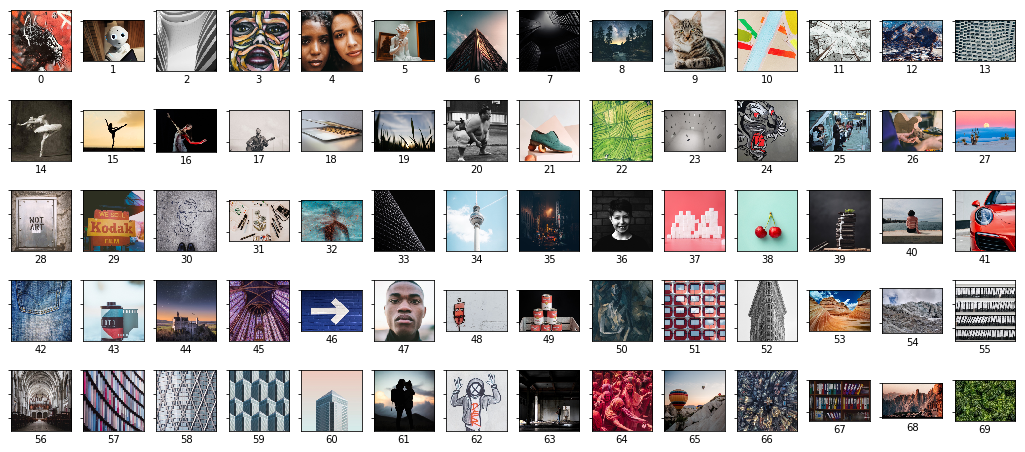

In [83]:
%matplotlib inline

from matplotlib import pyplot as plt

# Loading
images = tutorial.load_styletransfer_images()

# Visualization
fig, axes = plt.subplots(5,14, figsize=(18, 8))
for i, (image, ax) in enumerate(zip(images, axes.flatten())):
    tutorial.show_image(image, ax=ax, title=str(i))

These images are PyTorch tensors on the GPU. Their shape is (batch size=1, rgb=3, height, width):

In [84]:
images[0].shape

torch.Size([1, 3, 256, 256])

You can choose any two images from this set as style and content images.

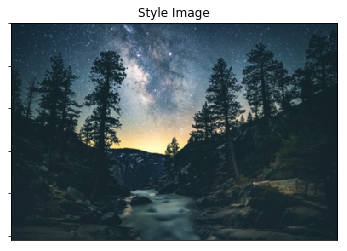

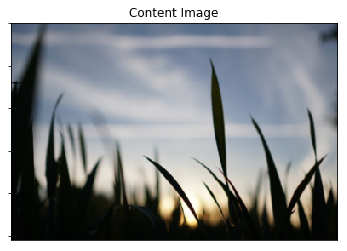

In [85]:
%matplotlib inline
style_img = images[8]  # TODO: Pick images you like
content_img = images[19]

plt.figure()
tutorial.show_image(style_img, title='Style Image')

plt.figure()
tutorial.show_image(content_img, title='Content Image')

## Modified VGG network

We modified the VGG19 model to return intermediate activations instead of image class predictions. Note how the `forward()` method runs the layer one by one, and collects their outputs.

In [86]:
class VGGActivations(torch.nn.Module):
    def __init__(self):
        """
        This is a 'prefix' (first few layers) of the VGG19 network.
        Instead of caring about the class predictions VGG produces for an image,
        we are just interested in the intermediate activation values between layers.
        That's why we chopped off the prediction part of the network.
        """
        super(VGGActivations, self).__init__()
        self.layers = [
            torch.nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            
            torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            
            torch.nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            
            torch.nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            
            # ... the original VGG19 has more layers
        ]
        
        # These are the normalization parameters the net was trained with
        self.normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to('cuda').view(1, 3, 1, 1)
        self.normalization_std = torch.tensor([0.229, 0.224, 0.225]).to('cuda').view(1, 3, 1, 1)

        # Register the layers so they are recognized by PyTorch as 'dependent modules'
        for i, layer in enumerate(self.layers):
            self.add_module(str(i), layer)

    def forward(self, x):
        """
        Instead of the normal forward function, which returns the predictions,
        we now keep track of the outputs (=activations) of each intermediate convolution layer.
        These activations are what we return.
        """
        # Normalization
        x = (x - self.normalization_mean) / self.normalization_std
        
        # We will store intermediate activation values in a dictionary
        activations = {}
        
        for layer_number, layer in enumerate(self.layers):
            x = layer(x)
            if isinstance(layer, torch.nn.Conv2d):
                activations[layer_number] = x  # shape: (batch size=1, num features=?, height, width)
                
        return activations

# Instantiate the model
net = VGGActivations().to('cuda').eval()

# Load pre-trained weights for the network from ImageNet
result = net.load_state_dict(torch.load("/shared/styletransfer/state_dict.pt"), strict=False)

## Loss function

The loss function requires the activation values of the style image and content image.

In [ ]:
### EXERCISE
#   Compute VGG activations for the style and content images, using the model we defined before
style_activations = # ...
content_activations = # ...

In [ ]:
### EXERCISE
#   Make sure these activation values are treated a constants.
#   Delete all their gradient information. You can use `tensor = tensor.data` or tensor.detach_() for this.
for _, tensor in style_activations.items():
    # ...
for _, tensor in content_activations.items():
    # ...

### Content loss


In [ ]:
def compute_content_loss(activations: dict):
    """
    :param activations: dictionary [number] -> torch.Tensor
    :return scalar - loss value
    """
    ### EXERCISE
    #   Implement the content loss
    #   Compare the activation values of the 4th convolutional layer of VGG19 (number 7 as returned by our model)
    #   Return the MSE between the current activations and those of the `content_img`
    
    target = content_activations[7]
    current = activations[7]
    # ...

### Style loss

In [ ]:
### EXERCISE 
#   In Neural Style Transfer, the style loss is the sum of MSE's between gram matrices at different layers.
#   A Gram matrix G of two lists of n vectors has shape (n x n) and is defined as follows:
#   It's entry G_ij = dot product(vector i, vector j)

def gram_matrix(activations_tensor: torch.Tensor):
    """
    :param activations_tensor: torch.Tensor of shape (1, num features, height, width)
    :return torch.Tensor of shape (num features, num features)
    """
    batch_size, n_features, height, width = activations_tensor.size()
    assert batch_size == 1

    ### EXERCISE
    #   Compute the gramm matrix G, considering the activations
    #   You can do this with matrix multiplication and reshaping (torch.view)
    # ...
    # ...

    # We 'normalize' the values of the gram matrix
    # by dividing it by the number of elements in each feature map.
    return gram_matrix.div(n_features * height * width)

def compute_style_loss(activations: dict):
    """
    :param activations: dictionary [number] -> torch.Tensor
    :return scalar - loss value
    """
    loss = 0.0
    for layer in [0, 2, 5, 7, 10]:
        ### EXERCISE
        #   Compute the Mean Squared Error between the gram matrices
        #   of the 'target' activations and the current activations (the function argument)
        #   Add it to the 'loss' for each layer in the loop.
        # ...
        # ...
        loss += # ...
    return loss

In [ ]:
def compute_losses(activations: dict, mix_weight = 1000000):
    content_loss = compute_content_loss(activations)
    style_loss = compute_style_loss(activations)
    total_loss = content_loss + mix_weight * style_loss
    return total_loss, mix_weight * style_loss, content_loss

## Optimization time

We initialize the image to be optimized as the content image:

In [ ]:
%matplotlib inline

# Image initialization

image = content_img.clone()
image.requires_grad_()  # Mark that gradients should be computed for this tensor

plt.figure()
tutorial.show_image(image, title='Initial image')

In [ ]:
### EXERCISE
#   Optimize the image according to the neural style transfer loss

# TODO: Choose an optimizer to optimize the 'image' tensor. 
#       You could try SGD with 0.9 Nesterov momentum and a lr of 0.01
#       or LBFGS (used in original tutorial, gives good results but is more difficult to implement -- https://pytorch.org/docs/stable/_modules/torch/optim/lbfgs.html)
#       Feel free to experiment with this.
#       How consistent are the outcomes?
optimizer = torch.optim.SGD([image], lr=0.01, momentum=0.9, nesterov=True)

plot = tutorial.LivePlot(legend=['Content loss', 'Style loss', 'Total loss'])

for step in range(500):  # or as long as you have patience
    activations = net(image)
    loss, style_loss, content_loss = compute_losses(activations)
    plot.add_point(step, content_loss.item(), style_loss.item(), loss.item())

    # EXERCISE: Optimization step
    # ...
    # ...
    # ...
    
    # EXERCISE: Project the image to stay in the range 0–1 (hint: use tensor.clamp or tensor.data.clamp_)
    # ...


In [ ]:
%matplotlib inline
plt.figure()
tutorial.show_image(image, title='Optimized')
plt.figure()
tutorial.show_image(style_img, title='Style image')

# Feedback
Please help us improve the lecture and tutorial by answering the questions below:

In [88]:
tutorial.lecture_questionnaire()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [90]:
tutorial.tutorial_questionnaire()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [92]:
# List any other feedback below
tutorial.answer("feedback", """
Very interesting. Not very difficult, but enough to think a little bit. 
Good work of the lector and assistants.
Thanks a lot!
""")